In [ ]:
!pip install plotly
!pip install --upgrade nbformat
!pip install nltk
!pip install spacy # spaCy is an open-source software library for advanced natural language processing
!pip install WordCloud
!pip install gensim # Gensim is an open-source library for unsupervised topic modeling and natural language processing
import nltk
nltk.download('punkt')

import tensorflow as tf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud, STOPWORDS
import nltk
import re
from nltk.stem import PorterStemmer, WordNetLemmatizer
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize, sent_tokenize
import gensim
from gensim.utils import simple_preprocess
from gensim.parsing.preprocessing import STOPWORDS
# import keras
from tensorflow.keras.preprocessing.text import one_hot, Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Embedding, Input, LSTM, Conv1D, MaxPool1D, Bidirectional
from tensorflow.keras.models import Model

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [ ]:
#load the data
df_true = pd.read_csv("/content/Fake.csv")
df_fake = pd.read_csv("/content/True.csv")

#check for general info
df_true.info()
df_fake.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23481 entries, 0 to 23480
Data columns (total 4 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   title    23481 non-null  object
 1   text     23481 non-null  object
 2   subject  23481 non-null  object
 3   date     23481 non-null  object
dtypes: object(4)
memory usage: 733.9+ KB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21417 entries, 0 to 21416
Data columns (total 4 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   title    21417 non-null  object
 1   text     21417 non-null  object
 2   subject  21417 non-null  object
 3   date     21417 non-null  object
dtypes: object(4)
memory usage: 669.4+ KB


In [ ]:
# add a target class column to indicate whether the news is real or fake
df_true['isfake'] = 1
df_fake['isfake'] = 0

In [ ]:
# concatenate Real and Fake News
df = pd.concat([df_true, df_fake]).reset_index(drop = True)

# drop 'date
df.drop(columns = ['date'], inplace = True)

# combine title and text together
df['original'] = df['title'] + ' ' + df['text']

In [ ]:
# download stopwords
nltk.download("stopwords")

# obtain additional stopwords from nltk
from nltk.corpus import stopwords
stop_words = stopwords.words('english')
stop_words.extend(['from', 'subject', 're', 'edu', 'use'])

# remove stopwords and remove words with 2 or less characters
def preprocess(text):
    result = []
    for token in gensim.utils.simple_preprocess(text):
        if token not in gensim.parsing.preprocessing.STOPWORDS and len(token) > 3 and token not in stop_words:
            result.append(token)

    return result

# apply the function to the dataframe
df['clean'] = df['original'].apply(preprocess)

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [ ]:
# obtain the total words present in the dataset
list_of_words = []
for i in df.clean:
    for j in i:
        list_of_words.append(j)

len(list_of_words)

9276947

In [ ]:
# obtain the total number of unique words
total_words = len(list(set(list_of_words)))
total_words

108704

In [ ]:
# join the words into a string
df['clean_joined'] = df['clean'].apply(lambda x: " ".join(x))

<Axes: xlabel='count', ylabel='subject'>

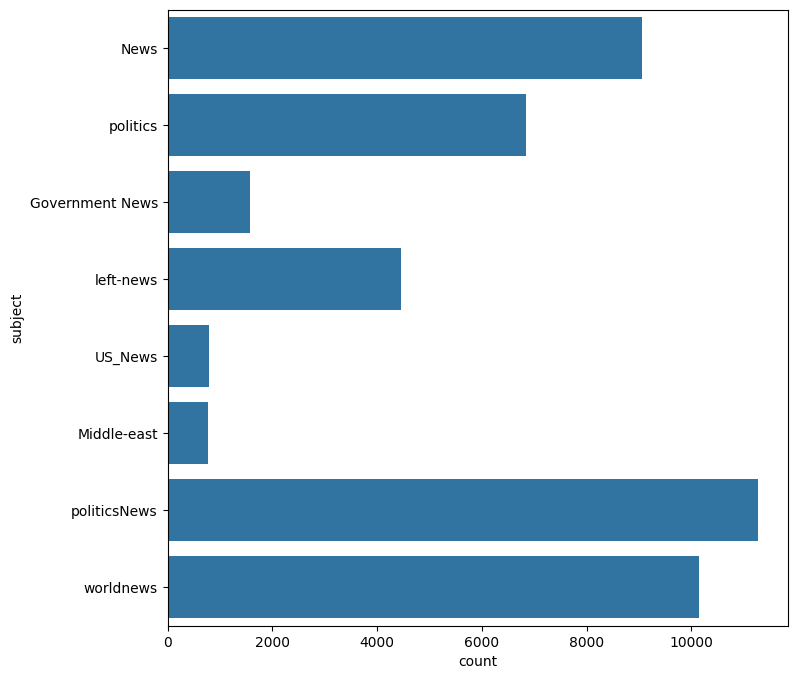

In [ ]:
# plot the number of samples in 'subject'
plt.figure(figsize = (8, 8))
sns.countplot(y = "subject", data = df)

<Axes: xlabel='count', ylabel='isfake'>

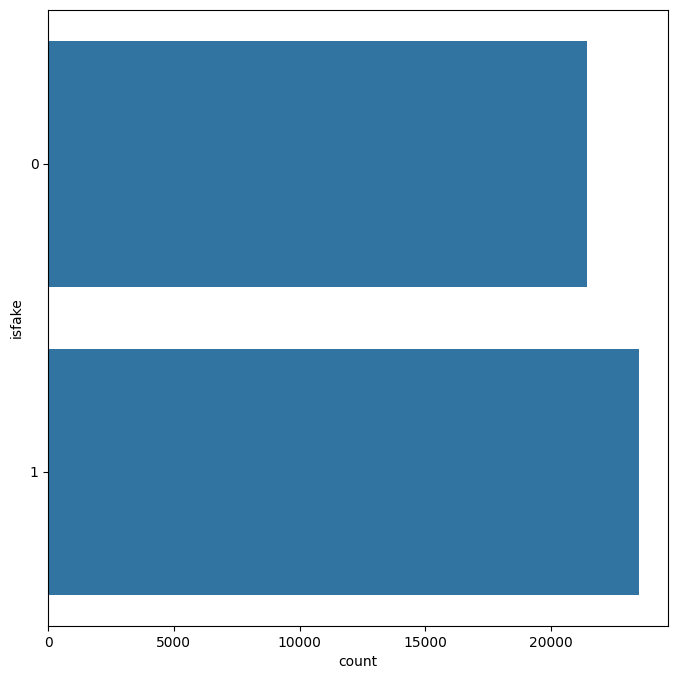

In [ ]:
# plot classes
plt.figure(figsize = (8, 8))
sns.countplot(y = "isfake", data = df)

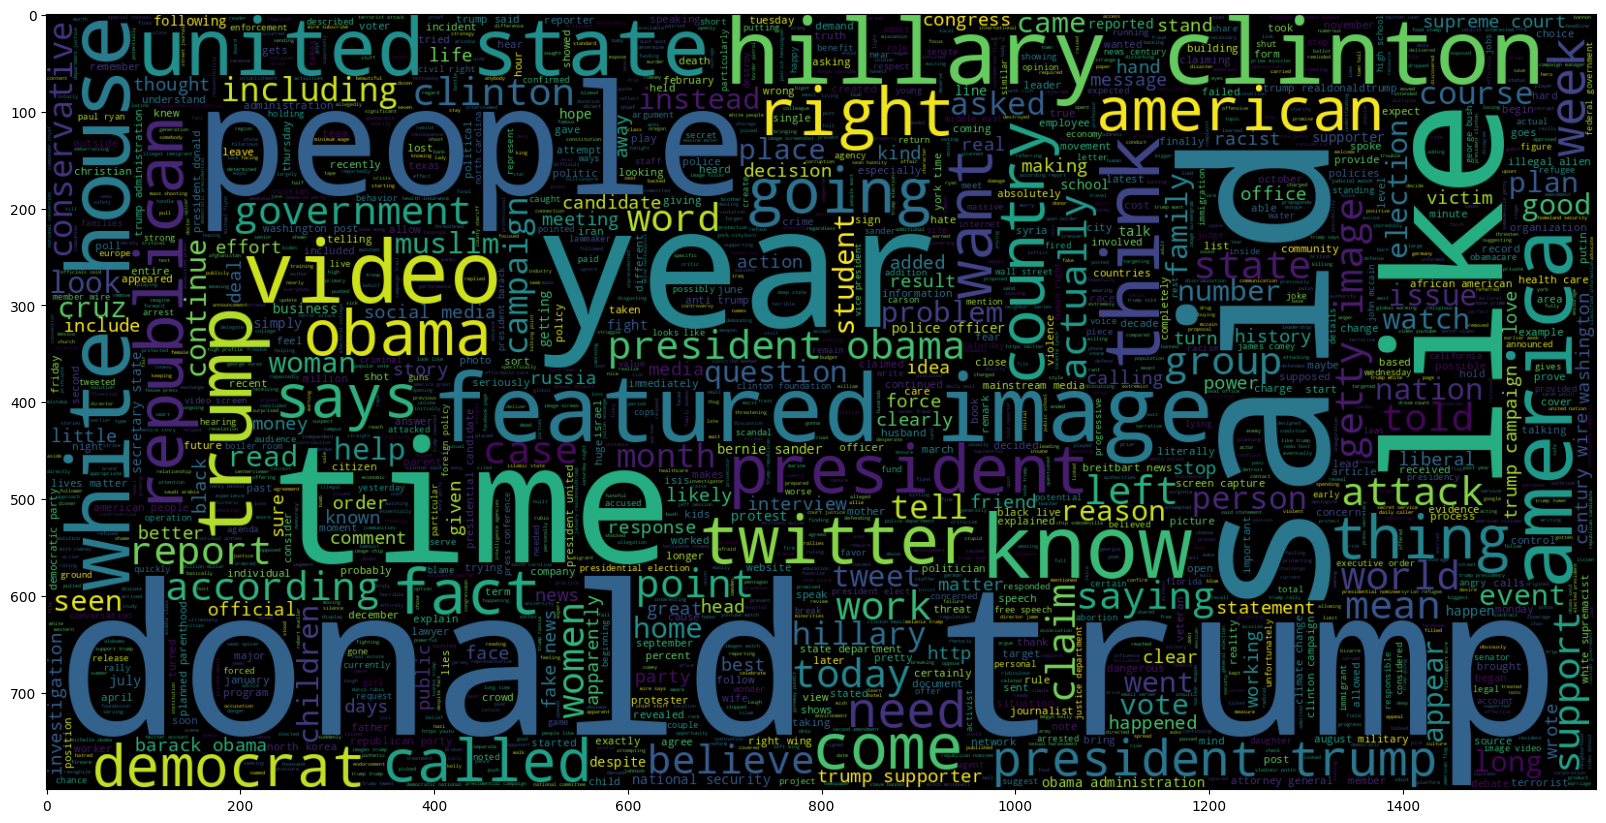

In [ ]:

# plot the word cloud for text that is Real
plt.figure(figsize = (20,20))
wc = WordCloud(max_words = 2000 , width = 1600 , height = 800 , stopwords = stop_words).generate(" ".join(df[df.isfake == 1].clean_joined))
plt.imshow(wc, interpolation = 'bilinear')

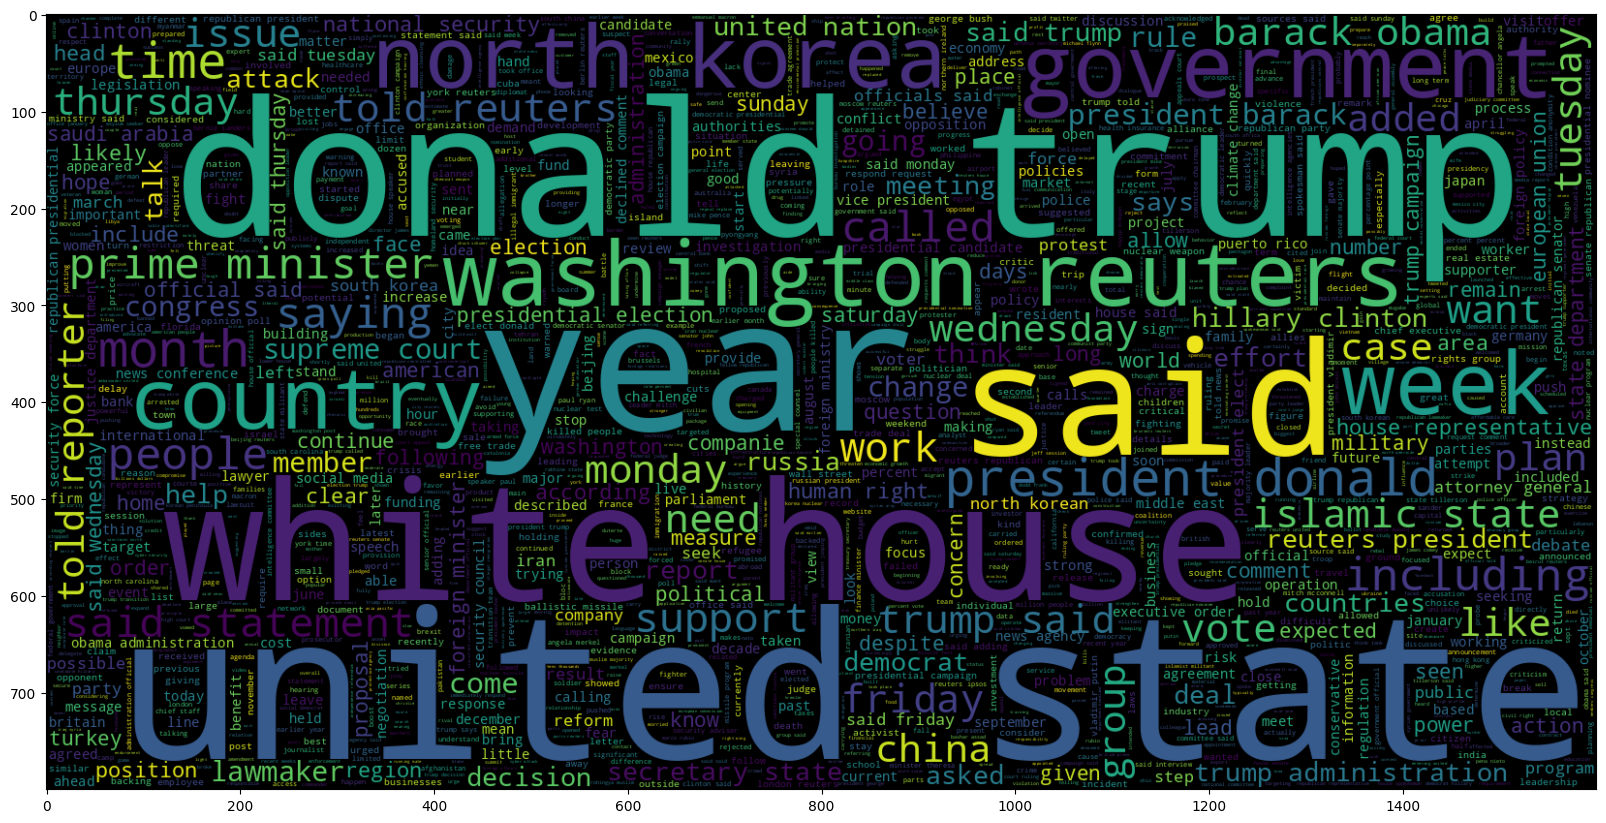

In [ ]:
# plot the word cloud for text that is Fake
plt.figure(figsize = (20,20))
wc = WordCloud(max_words = 2000 , width = 1600 , height = 800 , stopwords = stop_words).generate(" ".join(df[df.isfake == 0].clean_joined))
plt.imshow(wc, interpolation = 'bilinear')

In [ ]:
# visualize the distribution of number of words in a text
import plotly.express as px
fig = px.histogram(x = [len(nltk.word_tokenize(x)) for x in df.clean_joined], nbins = 100)
fig.show()

In [ ]:
# length of maximum document will be needed to create word embeddings
maxlen = -1
for doc in df.clean_joined:
    tokens = nltk.word_tokenize(doc)
    if(maxlen<len(tokens)):
        maxlen = len(tokens)
print("The maximum number of words in any document is =", maxlen)

The maximum number of words in any document is = 4405


In [ ]:
# split data into test and train
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(df.clean_joined, df.isfake, test_size = 0.2)

# create a tokenizer to tokenize the words and create sequences of tokenized words
tokenizer = Tokenizer(num_words = total_words)
tokenizer.fit_on_texts(x_train)
train_sequences = tokenizer.texts_to_sequences(x_train)
test_sequences = tokenizer.texts_to_sequences(x_test)

# add padding can either be maxlen = 4406 or smaller number maxlen = 40 seems to work well based on results
padded_train = pad_sequences(train_sequences,maxlen = 40, padding = 'post', truncating = 'post')
padded_test = pad_sequences(test_sequences,maxlen = 40, truncating = 'post')

# process label
y_train = np.asarray(y_train)

In [ ]:
# sequential Model
model = Sequential()

# embeddidng layer
model.add(Embedding(total_words, output_dim = 128))
# model.add(Embedding(total_words, output_dim = 240))


# bi-directional RNN and LSTM
model.add(Bidirectional(LSTM(128)))

# dense layers
model.add(Dense(128, activation = 'relu'))
model.add(Dense(1,activation= 'sigmoid'))

#model summary
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, None, 128)         13914112  
                                                                 
 bidirectional (Bidirection  (None, 256)               263168    
 al)                                                             
                                                                 
 dense (Dense)               (None, 128)               32896     
                                                                 
 dense_1 (Dense)             (None, 1)                 129       
                                                                 
Total params: 14210305 (54.21 MB)
Trainable params: 14210305 (54.21 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


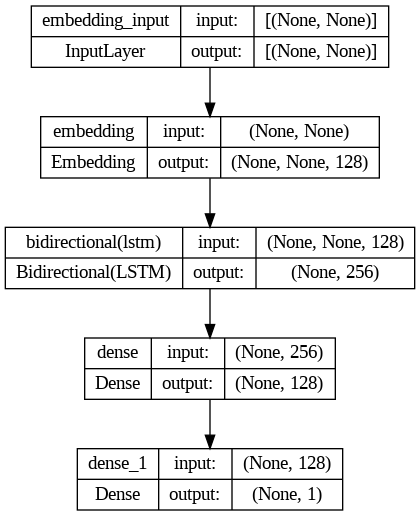

In [ ]:

from keras.utils import plot_model
#plot
plot_model(model, to_file = 'model_plot.png', show_shapes = True, show_layer_names = True)


In [ ]:
# compile
model.compile(loss='binary_crossentropy',
             optimizer='adam',
             metrics=['accuracy'])

# add callbacks
from keras.callbacks import EarlyStopping, ModelCheckpoint

# define the callbacks
early_stopping = [EarlyStopping(monitor = 'val_loss', patience = 5, verbose = 1),
                 ModelCheckpoint(filepath = 'model.h5', monitor = 'val_loss', save_best_only = True)]

# train the model
history = model.fit(padded_train, y_train,
                    batch_size = 64,
                    validation_split = 0.25,
                    epochs = 20,
                    callbacks = early_stopping)

Epoch 1/20
421/421 [==============================] - ETA: 0s - loss: 0.0477 - accuracy: 0.9830

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning:

You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.



421/421 [==============================] - 231s 535ms/step - loss: 0.0477 - accuracy: 0.9830 - val_loss: 0.0081 - val_accuracy: 0.9987
Epoch 2/20
276/421 [==================>...........] - ETA: 1:13 - loss: 0.0034 - accuracy: 0.9994

In [ ]:
# plot the training artifacts
fig , ax = plt.subplots(1, 2)
fig.set_size_inches(20, 10)

train_acc = history.history['accuracy']
train_loss = history.history['loss']
val_acc = history.history['val_accuracy']
val_loss = history.history['val_loss']

epochs = range(1, len(train_acc) + 1)

ax[0].plot(epochs, train_acc , 'go-' , label = 'Training Accuracy')
ax[0].plot(epochs , val_acc , 'yo-' , label = 'Validation Accuracy')
ax[0].set_title('Model Train & Validation Accuracy')
ax[0].legend()
ax[0].set_xlabel('Epochs')
ax[0].set_ylabel('Accuracy')

ax[1].plot(epochs, train_loss , 'go-' , label = 'Training Loss')
ax[1].plot(epochs, val_loss , 'yo-' , label = 'Validation Loss')
ax[1].set_title('Model Train & Validation Loss')
ax[1].legend()
ax[1].set_xlabel('Epochs')
ax[1].set_ylabel('Loss')

plt.show()

In [ ]:
# evaluate trained model
print('Train loss & accuracy:', model.evaluate(padded_train, y_train))
print('\n')
print('Test loss & accuracy:', model.evaluate(padded_test, y_test))

In [ ]:
# make prediction
pred = model.predict(padded_test)

# if the predicted value is >0.5 it is real else it is fake
prediction = []
for i in range(len(pred)):
    if pred[i].item() > 0.5:
        prediction.append(1)
    else:
        prediction.append(0)

In [ ]:
# getting the accuracy
from sklearn.metrics import accuracy_score

accuracy = accuracy_score(list(y_test), prediction)

print("Model Accuracy : ", accuracy)

In [ ]:
from sklearn.metrics import classification_report

#get classification report
print(classification_report(list(y_test), prediction, target_names = ['fake (Class 0)','real (Class 1)']))


In [ ]:
# plot confusion matrix function
from sklearn.metrics import confusion_matrix
import seaborn as sns

def plot_cm(y_true, y_pred, figsize=(10, 8)):
    cm = confusion_matrix(y_true, y_pred, labels=np.unique(y_true))
    cm_sum = np.sum(cm, axis=1, keepdims=True)
    cm_perc = cm / cm_sum.astype(float) * 100
    annot = np.empty_like(cm).astype(str)
    nrows, ncols = cm.shape
    for i in range(nrows):
        for j in range(ncols):
            c = cm[i, j]
            p = cm_perc[i, j]
            if i == j:
                s = cm_sum[i]
                annot[i, j] = '%.1f%%\n%d/%d' % (p, c, s)
            elif c == 0:
                annot[i, j] = ''
            else:
                annot[i, j] = '%.1f%%\n%d' % (p, c)
    cm = pd.DataFrame(cm, index=np.unique(y_true), columns=np.unique(y_true))
    cm.index.name = 'Actual'
    cm.columns.name = 'Predicted'
    fig, ax = plt.subplots(figsize=figsize)
    sns.heatmap(cm, cmap= plt.cm.Blues, annot=annot, fmt='', ax=ax)

#apply function
plot_cm(list(y_test), prediction)

In [ ]:
from sklearn.metrics import roc_auc_score, roc_curve

#roc curve
fpr, tpr, thresholds = roc_curve(list(y_test), prediction)
auc = roc_auc_score(list(y_test), prediction)
print('AUC:', auc)

plt.figure(figsize = (10, 6))
plt.plot(fpr, tpr, color = 'yellow', label = 'ROC curve (area = %f)' % auc)
plt.plot([0, 1], [0, 1], linestyle = '--', color = 'darkgreen')
plt.xlim([-0.1, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Model Fake News Classification')
plt.legend(loc = "lower right")
plt.show()
